In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
import nltk
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.manifold import TSNE

# Loading Data

In [2]:
data = pd.read_csv('QueryResults2.csv')
data = data.set_index('Id')

In [3]:
data.head()

,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
Id,,,,,,,,,,,,,,,,,,,,,
591865,1,591935,NaN,2009-02-26 18:38:03,NaN,5,7386,<p>I have some exposure to CakePHP and think i...,191083.0,bLee,...,2010-12-11 21:30:41,2012-12-15 16:53:39,Qcodo vs. CakePHP vs. Zend,<php><zend-framework><cakephp><qcodo>,9,0,5.0,2012-11-25 08:24:26,NaN,CC BY-SA 2.5
591892,1,614382,NaN,2009-02-26 18:43:23,NaN,104,87988,"<p>I'm looking for recommendations of a good, ...",20860.0,Bill Karwin,...,2013-09-25 20:29:59,2013-09-25 20:29:59,Tools for Generating Mock Data?,<testing><data-generation>,16,3,134.0,2013-07-23 21:38:25,NaN,CC BY-SA 2.5
41441462,1,41441526,NaN,2017-01-03 10:32:20,NaN,6,16648,<p>I have <code>centos7</code> <code>php56</co...,5010413.0,NaN,...,NaN,2017-01-03 10:35:16,Laravel: The use statement with non-compound n...,<php><laravel><caching>,2,2,1.0,2017-01-03 11:09:49,NaN,CC BY-SA 3.0
9552725,1,10011634,NaN,2012-03-04 05:59:27,NaN,4,26053,"<p>A <a href=""http://docs.oracle.com/javase/7/...",666891.0,NaN,...,2017-10-17 00:58:32,2017-10-17 00:58:32,Add trustStore for client authentication,<java><ssl><keystore><truststore>,2,0,5.0,2017-10-17 00:47:12,NaN,CC BY-SA 3.0
33014984,1,33015045,NaN,2015-10-08 11:50:55,NaN,0,68,<pre><code>using System;\n\nnamespace ConsoleA...,1939432.0,NaN,...,2015-10-08 11:54:41,2015-10-08 11:54:41,Unassigned variable error,<c#><unassigned-variable>,2,2,NaN,2015-10-08 11:54:21,NaN,CC BY-SA 3.0


Let's take only values that have a score >= 0 to be sure we don't have bad question (implying bad key words)

In [4]:
#data = data[data['Score'] >= 0]

# Working on the tags

## Cleaning

In [5]:
tags = data[['Tags']].copy()
# Let's first remplace the '<'
tags['Tags'].replace('<', '', regex=True, inplace=True)

# We then split with pattern '>'
tags['preprocessedTags'] = tags['Tags'].str.split(pat='>')
tags['Tags_'] = [' '.join(map(str, l)) for l in tags["preprocessedTags"]]

## Analysis

Let's first analyse the tags, see the repartition of nbr of tags per question, and the number of unique tags

In [6]:
tagsAnalysis = tags.copy()
tagsAnalysis['Tags'] = [' '.join(map(str, l)) for l in tagsAnalysis["preprocessedTags"]]
tagsAnalysis["tag_count"] = tagsAnalysis["Tags"].apply(lambda x : len(x.split()))

In [7]:
print( "Maximum number of tags in a question: ", tagsAnalysis["tag_count"].max())
print( "Minimum number of tags in a question: ", tagsAnalysis["tag_count"].min())
print( "Average number of tags in a question: ", tagsAnalysis["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.7087


[]

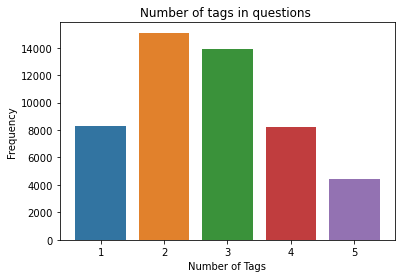

In [8]:
sns.countplot(tagsAnalysis["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.plot()

Let's see how many unique tags we have in our DataFrame

In [9]:
uniqueTags = [item for sublist in tagsAnalysis['preprocessedTags'] for item in sublist]
multipleTags = uniqueTags.copy()
uniqueTags = list(dict.fromkeys(uniqueTags))
uniqueTags.remove('')
print("Number of unique tags: ",len(uniqueTags))

Number of unique tags:  9755


In [10]:
multipleTags_df = pd.DataFrame(multipleTags, columns=['Tags'])
multipleTags_df = multipleTags_df[multipleTags_df['Tags'] != '']
multipleTags_df['Count'] = 1
multipleTags_df = multipleTags_df.groupby('Tags').count()

In [11]:
multipleTags_sorted = multipleTags_df.sort_values(by='Count', ascending=False)
multipleTags_sorted.head()

,Count
Tags,
java,5858
javascript,5841
php,5510
c#,4431
python,4326


As there is many tags that appears only few times, let's see how much we have that appears more than 30 times

In [12]:
print("Number of tags that appears more than 80 times: ", len(multipleTags_df[multipleTags_df['Count'] > 80]))

Number of tags that appears more than 80 times:  206


Let's see the 20 most common tags

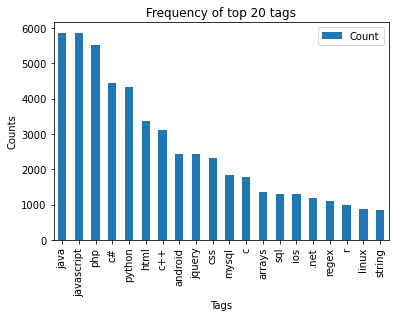

In [13]:
i=np.arange(20)
multipleTags_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, multipleTags_sorted.head(20).index)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

## Keeping only the common tags for modeling

The goal of this section is to clean the tags inside the Dataset ; We'll keep only the tags that appears more than 100 times

In [14]:
tagsToKeep = multipleTags_df[multipleTags_df['Count'] > 80].reset_index().drop(columns=['Count'])['Tags']

In [15]:
multipleTags_df[multipleTags_df['Count'] > 80].sort_values(ascending=True, by='Count')

,Count
Tags,
browser,81
jdbc,81
editor,82
split,83
java-8,84
...,...
python,4326
c#,4431
php,5510


In [16]:
# First we merge the preprocessedTags into the main df
dataTags = pd.merge(data, tags, left_index=True, right_index=True, how='inner')

In [17]:
# Then we keep only the question where one of the tagsToKeep is in
realTags = []
for ind in dataTags['preprocessedTags']:
    t = []
    for val in ind:
        if val in tagsToKeep.values:
            t.append(val)
    realTags.append(t)
    
realTags = pd.DataFrame({"preprocessedTags": realTags})
realTags.index = dataTags.index

In [18]:
dataTags = dataTags.drop(columns=['preprocessedTags'])
dataTags = pd.merge(dataTags, realTags, left_index=True, right_index=True, how='inner')

In [19]:
preprocessed_df = dataTags[['Body', 'Tags_']]

In [20]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags_'])

In [21]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [22]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

In [23]:
print(questions_covered[1],"% of questions covered by 200 tags")
print("Number of questions that are not covered by 200 tags : ", questions_covered_fn(100),"out of ", total_qus)

94.02 % of questions covered by 200 tags
Number of questions that are not covered by 200 tags :  4927 out of  50000


# Description

## Cleaning

In [24]:
description = dataTags[['Title','Body']].copy()
# Let's add the title to the body
description['Body'] = description[['Title','Body']].apply(lambda x: ' '.join(x), axis=1)
description['Body'] = description[['Title','Body']].apply(lambda x: ' '.join(x), axis=1)
description = description[['Body']]

In [25]:
description['Body']

Id
591865      Qcodo vs. CakePHP vs. Zend Qcodo vs. CakePHP v...
591892      Tools for Generating Mock Data? Tools for Gene...
41441462    Laravel: The use statement with non-compound n...
9552725     Add trustStore for client authentication Add t...
33014984    Unassigned variable error Unassigned variable ...
                                  ...                        
18363295    jQuery: unbinding event of child? jQuery: unbi...
18363308    what is the best way to remove words from rich...
8625692     Array output miscellaneous Array output miscel...
19723361    Is it ok to have a pointer to an invalid locat...
25303563    Making a Circular Dial like menu Making a Circ...
Name: Body, Length: 50000, dtype: object

### HTML tags

In [26]:
parser = lambda x: html.fromstring(x).text_content()
description['Body_Cleaned'] = list(map(parser, description['Body']))
description['Body_Cleaned'].replace(r'\n', '', regex=True, inplace=True)
# There is still some html tags, let's remove them with a regex
TAG_RE = re.compile(r'<[^>]+>')
tags_re = lambda x: TAG_RE.sub('', x)
description['Body_Cleaned'] = list(map(tags_re, description['Body_Cleaned']))

In [27]:
description = description.drop(columns=['Body'])

### Normalisation

The goal here is to extract the frequences of the words

In [28]:
data_cleaned = pd.merge(dataTags, description, left_index=True,
                        right_index=True, how='inner')

data_cleaned = data_cleaned[['Title', 'Body_Cleaned', 'preprocessedTags']]

In [29]:
data_cleaned.head()

,Title,Body_Cleaned,preprocessedTags
Id,,,
591865,Qcodo vs. CakePHP vs. Zend,Qcodo vs. CakePHP vs. Zend Qcodo vs. CakePHP v...,[php]
591892,Tools for Generating Mock Data?,Tools for Generating Mock Data? Tools for Gene...,[testing]
41441462,Laravel: The use statement with non-compound n...,Laravel: The use statement with non-compound n...,"[php, laravel]"
9552725,Add trustStore for client authentication,Add trustStore for client authentication Add t...,[java]
33014984,Unassigned variable error,Unassigned variable error Unassigned variable ...,[c#]


### Stop Words

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mlmaster/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# First we get the freq of words on our dataset
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_cleaned.index:
    desc[i] += tokenizer.tokenize(data_cleaned.loc[i, 'Body_Cleaned'].lower())
    
stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

In [32]:
freq_totale = nltk.Counter()
for k, v in zip(desc.keys(), desc.values()):
    freq_totale += freq[k]

In [33]:
freq_totale_sorted = pd.DataFrame.from_dict(freq_totale, orient='index').sort_values(by=0, ascending=False)
freq_totale_sorted = freq_totale_sorted[freq_totale_sorted[0] <= 18000]

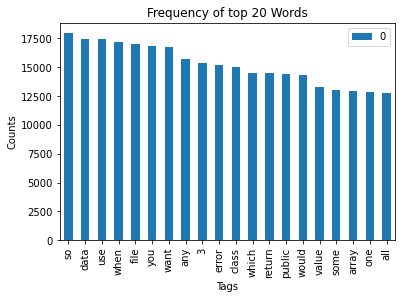

In [34]:
i=np.arange(20)
freq_totale_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 Words')
plt.xticks(i, freq_totale_sorted.head(20).index)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [35]:
# Here is our list of stop words
to_keep = { key:value for (key,value) in freq_totale.items() if value <= 18000 and value >= 50}.keys()
# Let's add the common stop words list of nltk
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

In [36]:
len(to_keep)

6297

Let's clean the words in our description

In [37]:
stemmer = EnglishStemmer()

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = []
unstemmed_desc = []
i = 0
for index, row in data_cleaned.iterrows():
    if i%2000 == 0:
        print("Performing Step ", i, "/", data_cleaned.shape[0])
    token = tokenizer.tokenize(row['Body_Cleaned'].lower())
    description = [w for w in token if not w in list(sw) and w in list(to_keep)]
    unstemmed_desc.append(description)
    description = [stemmer.stem(w) for w in description]
    desc.append(description)
    i += 1

Performing Step  0 / 50000
Performing Step  2000 / 50000
Performing Step  4000 / 50000
Performing Step  6000 / 50000
Performing Step  8000 / 50000
Performing Step  10000 / 50000
Performing Step  12000 / 50000
Performing Step  14000 / 50000
Performing Step  16000 / 50000
Performing Step  18000 / 50000
Performing Step  20000 / 50000
Performing Step  22000 / 50000
Performing Step  24000 / 50000
Performing Step  26000 / 50000
Performing Step  28000 / 50000
Performing Step  30000 / 50000
Performing Step  32000 / 50000
Performing Step  34000 / 50000
Performing Step  36000 / 50000
Performing Step  38000 / 50000
Performing Step  40000 / 50000
Performing Step  42000 / 50000
Performing Step  44000 / 50000
Performing Step  46000 / 50000
Performing Step  48000 / 50000


In [38]:
data_cleaned_ = data_cleaned.copy() # Making sure we have a copy

In [39]:
data_cleaned['desc'] = [' '.join(map(str, l)) for l in desc]
data_cleaned['unstemmed_desc'] = [' '.join(map(str, l)) for l in unstemmed_desc]

In [40]:
data_cleaned = data_cleaned[['desc', 'unstemmed_desc', 'preprocessedTags']]
tags = pd.DataFrame(data_cleaned.preprocessedTags.tolist(),
                    columns=['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'],
                    index=data_cleaned.index)['Tag1']
data_cleaned = pd.merge(data_cleaned, tags, left_index=True, right_index=True, how='inner')
data_cleaned = data_cleaned.dropna()

In [41]:
data_cleaned

,desc,unstemmed_desc,preprocessedTags,Tag1
Id,,,,
591865,vs cakephp vs zend vs cakephp vs zend cakephp ...,vs cakephp vs zend vs cakephp vs zend cakephp ...,[php],php
591892,tool generat mock data tool generat mock data ...,tools generating mock data tools generating mo...,[testing],testing
41441462,laravel use statement non name cach effect lar...,laravel use statement non name cache effect la...,"[php, laravel]",php
9552725,add client authent add client authent server r...,add client authentication add client authentic...,[java],java
33014984,variabl error variabl error system namespac cl...,variable error variable error system namespace...,[c#],c#
...,...,...,...,...
18363295,jqueri event child jqueri event child anchor w...,jquery event child jquery event child anchor w...,"[javascript, jquery]",javascript
18363308,best way remov word best way remov word strong...,best way remove words best way remove words st...,"[c#, winforms]",c#
8625692,array output array output includ main 3 b 6 pr...,array output array output include main 3 b 6 p...,[c],c


# Saving data

In [42]:
import csv
to_keep_list = list(to_keep)
with open("Flask/to_keep.csv", 'w') as fp:
    wr = csv.writer(fp, quoting=csv.QUOTE_ALL)
    wr.writerow(to_keep_list)

sw_list = list(sw)
with open("Flask/sw.csv", 'w') as fp:
    wr = csv.writer(fp, quoting=csv.QUOTE_ALL)
    wr.writerow(sw_list)

FileNotFoundError: [Errno 2] No such file or directory: 'Flask/to_keep.csv'

In [43]:
data_cleaned.to_csv('data_cleaned.csv')